# Social Media Tweet Exploratory Data Analysis (EDA) on Twitter Dataset

## 1. Importing the necessary python packages 

In [4]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re
import sys

cwd = os.getcwd()
parent = cwd.replace('/JupyterNotebooks', '')
sys.path.insert(0, parent) 

# custom modules
from clean_tweets_dataframe import CleanTweets
from extract_dataframe import read_json, TweetDfExtracto

ImportError: cannot import name 'CleanTweets' from 'clean_tweets_dataframe' (/Users/user/TENAC/week0/Twitter-Data-Analysis/clean_tweets_dataframe.py)

## 2. Data acquisition
- get the data link [cleaned_fintech_data.csv ](https://developer.twitter.com/en) cleaned_fintech_data.csv 



In [2]:
#To read csv file and create dataframe
tweets = pd.read_csv('../cleaned_tweet_data.csv')
tweets.head()

,created_at,source,clean_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:07+00:00,"<a href=""http://twitter.com/download/android"" ...",china even cut communication anwer phonecalls ...,0.000000e+00,0.00000,en,0,0,fin21free,85,392,False,['xijinping'],['zelenskyyua'],netherlands
1,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...",putin told friend taiwan vassal state includin...,1.000000e-01,0.35000,en,0,0,fin21free,85,392,False,['xijinping'],[],netherlands
2,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",sorry thought taiwan independent country gover...,-6.938894e-18,0.55625,en,0,381,vizzinidolores,910,2608,False,[],['chinauncensored'],"ayent, schweiz"
3,2022-08-07 22:31:02+00:00,"<a href=""http://twitter.com/download/android"" ...",must let happen must ready must defend,2.000000e-01,0.50000,en,0,36,gracech15554845,207,54,False,['taiwan'],['benedictrogers'],"melbourne, victoria"
4,2022-08-07 22:30:59+00:00,"<a href=""http://twitter.com/download/android"" ...",singer roger waters rebukes says part know go ...,0.000000e+00,0.00000,en,0,5,nhohn2011,870,508,False,"['pinkfloyd', 'taiwan', 'china']",['chinainfo777'],"florida, usa"


In [44]:
# print the information regarding each columns in dataframe
tweets.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7229 entries, 1 to 12105
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          7229 non-null   object 
 1   source              7229 non-null   object 
 2   clean_text          7225 non-null   object 
 3   polarity            7229 non-null   float64
 4   subjectivity        7229 non-null   float64
 5   lang                7229 non-null   object 
 6   favorite_count      7229 non-null   int64  
 7   retweet_count       7229 non-null   int64  
 8   original_author     7229 non-null   object 
 9   followers_count     7229 non-null   int64  
 10  friends_count       7229 non-null   int64  
 11  possibly_sensitive  7229 non-null   bool   
 12  hashtags            7229 non-null   object 
 13  user_mentions       7229 non-null   object 
 14  place               7229 non-null   object 
 15  score               7229 non-null   object 
 16  score

In [45]:
missing_count = tweets.isnull().sum()

print(f"Missing value(s) count: \n{missing_count}")

Missing value(s) count: 
created_at            0
source                0
clean_text            4
polarity              0
subjectivity          0
lang                  0
favorite_count        0
retweet_count         0
original_author       0
followers_count       0
friends_count         0
possibly_sensitive    0
hashtags              0
user_mentions         0
place                 0
score                 0
scoremap              0
dtype: int64


In [3]:
def text_category(p)->str:
    if p<0:
        return 'negative'
    elif p==0:
        return 'neutral'
    else:
        return 'positive'

In [4]:
tweets['score'] = tweets['polarity'].apply(text_category)

<AxesSubplot:>

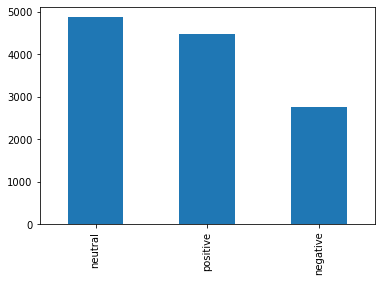

In [5]:
#barchart
tweets['score'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='score'>

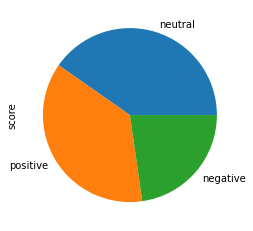

In [6]:
# piechar
tweets['score'].value_counts().plot(kind='pie')

- Remove rows from cleanTweet where  𝐩𝐨𝐥𝐚𝐫𝐢𝐭𝐲   =0  (i.e where  𝐬𝐜𝐨𝐫𝐞  = Neutral) and reset the frame index.

- Construct a column  𝐬𝐜𝐨𝐫𝐞𝐦𝐚𝐩  Use the mapping {'positive':1, 'negative':0} on the  𝐬𝐜𝐨𝐫𝐞  column

- Create feature and target variables (X,y) from  𝐜𝐥𝐞𝐚𝐧-𝐭𝐞𝐱𝐭  and  𝐬𝐜𝐨𝐫𝐞𝐦𝐚𝐩  columns respectively.

- Use train_test_split function to construct (X_train, y_train) and (X_test, y_test) from (X,y)

- Build an SGDClassifier model from the vectorize train text data. Use CountVectorizer() with a  trigram  parameter.

- Evaluate your model on the test data.

In [7]:
tweets = tweets[tweets['polarity']!=0]
tweets.reset_index()
tweets.head()

,created_at,source,clean_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,score
1,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...",putin told friend taiwan vassal state includin...,1.000000e-01,0.35000,en,0,0,fin21free,85,392,False,['xijinping'],[],netherlands,positive
2,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",sorry thought taiwan independent country gover...,-6.938894e-18,0.55625,en,0,381,vizzinidolores,910,2608,False,[],['chinauncensored'],"ayent, schweiz",negative
3,2022-08-07 22:31:02+00:00,"<a href=""http://twitter.com/download/android"" ...",must let happen must ready must defend,2.000000e-01,0.50000,en,0,36,gracech15554845,207,54,False,['taiwan'],['benedictrogers'],"melbourne, victoria",positive
7,2022-08-07 22:30:15+00:00,"<a href=""http://twitter.com/download/android"" ...",china largest taiwan military drills draw close,-1.000000e-01,0.10000,en,0,1,fortunefrien,336,1026,False,"['china', 'diplomacy', 'militarydrills', 'taiw...",['eaglenews'],"san jose del monte, central lu",negative
10,2022-08-07 22:28:44+00:00,"<a href=""http://twitter.com/download/android"" ...",opinion visit honour commitment democracy espe...,-3.750000e-01,1.00000,en,0,4,cyclorient,639,642,False,"['pelosi', 'taiwan']",['euobs'],"tokyo,japan",negative


In [8]:
tweets['scoremap'] = tweets['score'].apply(lambda x: 0 if x=='negative' else 1)
tweets.head()

,created_at,source,clean_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,score,scoremap
1,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...",putin told friend taiwan vassal state includin...,1.000000e-01,0.35000,en,0,0,fin21free,85,392,False,['xijinping'],[],netherlands,positive,1
2,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",sorry thought taiwan independent country gover...,-6.938894e-18,0.55625,en,0,381,vizzinidolores,910,2608,False,[],['chinauncensored'],"ayent, schweiz",negative,0
3,2022-08-07 22:31:02+00:00,"<a href=""http://twitter.com/download/android"" ...",must let happen must ready must defend,2.000000e-01,0.50000,en,0,36,gracech15554845,207,54,False,['taiwan'],['benedictrogers'],"melbourne, victoria",positive,1
7,2022-08-07 22:30:15+00:00,"<a href=""http://twitter.com/download/android"" ...",china largest taiwan military drills draw close,-1.000000e-01,0.10000,en,0,1,fortunefrien,336,1026,False,"['china', 'diplomacy', 'militarydrills', 'taiw...",['eaglenews'],"san jose del monte, central lu",negative,0
10,2022-08-07 22:28:44+00:00,"<a href=""http://twitter.com/download/android"" ...",opinion visit honour commitment democracy espe...,-3.750000e-01,1.00000,en,0,4,cyclorient,639,642,False,"['pelosi', 'taiwan']",['euobs'],"tokyo,japan",negative,0


In [40]:
X,y = np.array(tweets['clean_text'],dtype='unicode'), tweets['scoremap']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(X)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)

SGDClassifier()

In [43]:
clf.score(X_test,y_test)

0.8914501257334451